In [27]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from pathlib import Path

Below code is used to clean the data. Below steps are done
1. Read the CSV file from guthub and describe it
2. Identify the timestamp column, convert to datetime index, verify 10-minute interval
3. Remove any exact duplicate rows
4. Handle missing values and if found take a mean of it
5. Check for gaps any missing timestamps
6. Fill Categorical value with NAN

In [34]:
# CSV URL from gihub
RAW_URL = "https://raw.githubusercontent.com/ibimohamed83/Data_Analytics_project/refs/heads/main/dataset/energydata_complete.csv"
# Defining column name
DATE_COL = "date"
EXPECTED_FREQ = "10min"

In [35]:

# Read CSV + describe
df = pd.read_csv(RAW_URL)
# Describing the features in the csv file
print("Shape (rows, cols):", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nDtypes:\n", df.dtypes)

Shape (rows, cols): (19735, 29)

Columns:
 ['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2']

Dtypes:
 date               str
Appliances       int64
lights           int64
T1             float64
RH_1           float64
T2             float64
RH_2           float64
T3             float64
RH_3           float64
T4             float64
RH_4           float64
T5             float64
RH_5           float64
T6             float64
RH_6           float64
T7             float64
RH_7           float64
T8             float64
RH_8           float64
T9             float64
RH_9           float64
T_out          float64
Press_mm_hg    float64
RH_out         float64
Windspeed      float64
Visibility     float64
Tdewpoint      float64
rv1            float64
rv2            float64
dtype: object


In [5]:
# Identify timestamp, parse, set index
if DATE_COL not in df.columns:
    raise ValueError(f"Expected '{DATE_COL}' column not found.")

df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
bad_dates = int(df[DATE_COL].isna().sum())
print("\nBad/unparseable dates:", bad_dates)

# Drop rows with invalid timestamps (if any)
df = df.dropna(subset=[DATE_COL])

# Sort by time and set as index
df = df.sort_values(DATE_COL).set_index(DATE_COL)

# Verify 10-minute interval consistency
diffs = df.index.to_series().diff().dropna()
expected_delta = pd.Timedelta(EXPECTED_FREQ)
pct_expected = (diffs == expected_delta).mean() * 100

print("\nTime range:", df.index.min(), "->", df.index.max())
print(f"% intervals equal to {EXPECTED_FREQ}:", round(pct_expected, 2))
print("Most common time gaps:\n", diffs.value_counts().head(5))


Bad/unparseable dates: 0

Time range: 2016-01-11 17:00:00 -> 2016-05-27 18:00:00
% intervals equal to 10min: 100.0
Most common time gaps:
 date
0 days 00:10:00    19734
Name: count, dtype: int64


In [6]:
# Remove duplicates (rows and timestamps)
dup_rows = int(df.duplicated().sum())
dup_timestamps = int(df.index.duplicated().sum())

print("\nDuplicate rows found:", dup_rows)
print("Duplicate timestamps found:", dup_timestamps)

if dup_rows > 0:
    df = df.drop_duplicates()

if dup_timestamps > 0:
    df = df[~df.index.duplicated(keep="first")]


Duplicate rows found: 0
Duplicate timestamps found: 0


In [7]:
# Missing value handling:
# - Numeric -> mean
# - Categorical -> mode (most frequent)
missing_before = df.isna().sum().sum()
print("\nMissing before fill:", int(missing_before))

num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(exclude=[np.number]).columns

# Fill numeric NaNs with mean
for c in num_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].mean())

# Fill categorical NaNs with mode
for c in cat_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].mode(dropna=True).iloc[0])


Missing before fill: 0


In [9]:
# Gap check (missing timestamps)
# If gaps exist, document and decide interpolation vs removal
full_index = pd.date_range(df.index.min(), df.index.max(), freq=EXPECTED_FREQ)
missing_timestamps = full_index.difference(df.index)

print("\nMissing timestamps (gaps):", len(missing_timestamps))

# 6) Final check: confirm no NaNs remain
missing_after = int(df.isna().sum().sum())
print("\nMissing after fill:", missing_after)

assert missing_after == 0, "There are still missing values after cleaning!"

print("\nCleaning complete. Dataset is time-indexed and contains no missing values.")


Missing timestamps (gaps): 0

Missing after fill: 0

Cleaning complete. Dataset is time-indexed and contains no missing values.


Below code will identify the outliers using the IQR method. If any outliers observed consider for later use as these spikes may be genuine. Any sudden jumps or spikes observed will be later removed after proper analysis.

Does feature sanity check to make sure the temp and humidity is in vaid range 

In [ ]:
TARGET_COLS = ["Appliances", "lights"]
RV_COLS = ["rv1", "rv2"]

# time resolution settings
EXPECTED_FREQ = "10min"
SAMPLING_MINUTES = 10

# Rolling window chosen to represent 1 day:
# 24 hours * 60 minutes = 1440 minutes; 1440/10 = 144 points
ROLL_WIN = int((24 * 60) / SAMPLING_MINUTES)

# Rolling z-score threshold:
# Keeping this as a parameter so it can tune it after inspecting flagged points
Z_THRESH = 5

# Spike definition for energy: top 5% by default (95th percentile)
SPIKE_Q = 0.95

# Percentiles used for documentation of extremes (not automatic removal)
LOW_P, HIGH_P = 0.01, 0.99

# IQR fence multi
IQR_K = 3.0

# Fetching the columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
rv_cols = [c for c in RV_COLS if c in df.columns]
sensor_cols = [c for c in num_cols if c not in TARGET_COLS + rv_cols]

In [12]:
# Flag genuine energy spikes (do NOT remove)
spike_threshold = df["Appliances"].quantile(SPIKE_Q)
df["is_energy_spike"] = df["Appliances"] >= spike_threshold
print(f"Energy spike threshold (q={SPIKE_Q:.2f}): {spike_threshold:.2f} Wh")
print("Number of spike rows:", int(df["is_energy_spike"].sum()))

Energy spike threshold (q=0.95): 330.00 Wh
Number of spike rows: 1001


In [13]:
# Sanity checks (expected ranges)
# - Humidity should be 0–100
# - Temperature should be plausible in Celsius
# - Weather values should be plausible

humidity_cols = [c for c in df.columns if c.startswith("RH_")]
if "RH_out" in df.columns:
    humidity_cols.append("RH_out")

temp_cols = [c for c in df.columns if re.match(r"^T\d+$", c)]
for c in ["T_out", "Tdewpoint"]:
    if c in df.columns:
        temp_cols.append(c)

print("\nSanity ranges (before correction):")
print("Humidity min/max:", df[humidity_cols].min().min(), df[humidity_cols].max().max())
print("Temp min/max:", df[temp_cols].min().min(), df[temp_cols].max().max())
if "Press_mm_hg" in df.columns:
    print("Pressure min/max:", df["Press_mm_hg"].min(), df["Press_mm_hg"].max())

# Apply range rules: anything impossible becomes NaN (sensor glitch)
df_range = df.copy()

# Humidity: 0–100
for c in humidity_cols:
    df_range.loc[(df_range[c] < 0) | (df_range[c] > 100), c] = np.nan

# Temperatures: broad safe bounds
for c in temp_cols:
    df_range.loc[(df_range[c] < -30) | (df_range[c] > 60), c] = np.nan

# Weather sanity bounds (broad)
if "Press_mm_hg" in df_range.columns:
    df_range.loc[(df_range["Press_mm_hg"] < 600) | (df_range["Press_mm_hg"] > 820), "Press_mm_hg"] = np.nan
if "Windspeed" in df_range.columns:
    df_range.loc[(df_range["Windspeed"] < 0) | (df_range["Windspeed"] > 60), "Windspeed"] = np.nan
if "Visibility" in df_range.columns:
    df_range.loc[(df_range["Visibility"] < 0) | (df_range["Visibility"] > 100), "Visibility"] = np.nan

range_nan_added = int(df_range[sensor_cols].isna().sum().sum() - df[sensor_cols].isna().sum().sum())
print("\nNaNs introduced by range sanity checks (sensor glitches):", range_nan_added)


Sanity ranges (before correction):
Humidity min/max: 1.0 100.0
Temp min/max: -6.6 29.8566666666667
Pressure min/max: 729.3 772.3

NaNs introduced by range sanity checks (sensor glitches): 0


In [ ]:
# Robust extreme-value detection (IQR / percentile / rolling z-score)
# We only CORRECT values when rolling z-score indicates a sudden jump

def iqr_bounds(series, k=3.0):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    return q1 - k * iqr, q3 + k * iqr

# IQR flags (for documentation, not automatic removal)
iqr_flag_counts = {}
for c in sensor_cols:
    s = df_range[c].dropna()
    if s.empty:
        iqr_flag_counts[c] = 0
        continue
    low, high = iqr_bounds(s, k=3.0)
    iqr_flag_counts[c] = int(((df_range[c] < low) | (df_range[c] > high)).sum())

iqr_flag_counts = pd.Series(iqr_flag_counts).sort_values(ascending=False)
print("\nTop IQR-flagged sensor columns (documentation only):")
print(iqr_flag_counts.head(10))



Top IQR-flagged sensor columns (documentation only):
RH_5           542
RH_2             9
T2               5
RH_1             1
T1               0
T8               0
Visibility       0
Windspeed        0
RH_out           0
Press_mm_hg      0
dtype: int64


In [15]:
# Rolling z-score glitches (this is what we treat as "sensor glitch")
corrected_counts = {}
df_fixed = df_range.copy()

for c in sensor_cols:
    s = df_fixed[c]
    roll_mean = s.rolling(window=ROLL_WIN, min_periods=max(10, ROLL_WIN // 10)).mean()
    roll_std  = s.rolling(window=ROLL_WIN, min_periods=max(10, ROLL_WIN // 10)).std()
    z = (s - roll_mean) / roll_std.replace(0, np.nan)

    glitch_mask = z.abs() > Z_THRESH
    corrected_counts[c] = int(glitch_mask.sum())

    # Only correct sensor values (NOT energy targets)
    df_fixed.loc[glitch_mask, c] = np.nan

# Interpolate corrected sensor glitches
df_fixed[sensor_cols] = df_fixed[sensor_cols].interpolate(method="time").ffill().bfill()

corrected_counts = pd.Series(corrected_counts).sort_values(ascending=False)
print("\nTop rolling z-score corrections (sensor glitches removed):")
print(corrected_counts.head(10))
print("Total corrected points (sum across columns):", int(corrected_counts.sum()))

# Final NaN check
nan_total = int(df_fixed.isna().sum().sum())
print("\nTotal NaNs after corrections:", nan_total)



Top rolling z-score corrections (sensor glitches removed):
RH_5          163
T5             61
Visibility     46
RH_1           35
RH_6           21
T3             16
RH_3           12
T9             10
T7              9
T4              7
dtype: int64
Total corrected points (sum across columns): 382

Total NaNs after corrections: 0


Below plots were visualize
• Time-series plot
• Separate energy hour of day, separate weekdays or weekends plots
• Top N peak periods i.e., spike analysis charts
• Correlation heatmap i.e., energy vs sensor/weather
• Scatter plot for energy vs outdoor/indoor sensor

In [36]:
DATE_COL = "date"
TARGET_COL = "Appliances"
TOP_N_SPIKES = 20
SPIKE_Q = 0.95          # 95th percentile spike definition
ROLLING_WINDOW = 144    # 144 * 10-min = 1 day (for smoothing in plot)

# Parse datetime and set index
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df = df.dropna(subset=[DATE_COL]).sort_values(DATE_COL).set_index(DATE_COL)
# Candidate columns for scatter plots (will pick the ones that exist)
OUTDOOR_CANDIDATES = ["T_out", "RH_out", "Press_mm_hg", "Windspeed", "Visibility", "Tdewpoint"]
INDOOR_CANDIDATES = ["T1", "RH_1", "T2", "RH_2", "T5", "RH_5"]

Below is the Timeseries plot.  The plot uses appliance energy consumption which is recorded every 10 min. The target variable "APpliance" is used to plot the full energy consumption across 4.5 months. The sampling is done based on one-day rolling window. There are 2 spikes shown, blue spike for the raw series and orange for one day series which provides the short term spikes. 

Text(0, 0.5, 'Energy (Wh)')

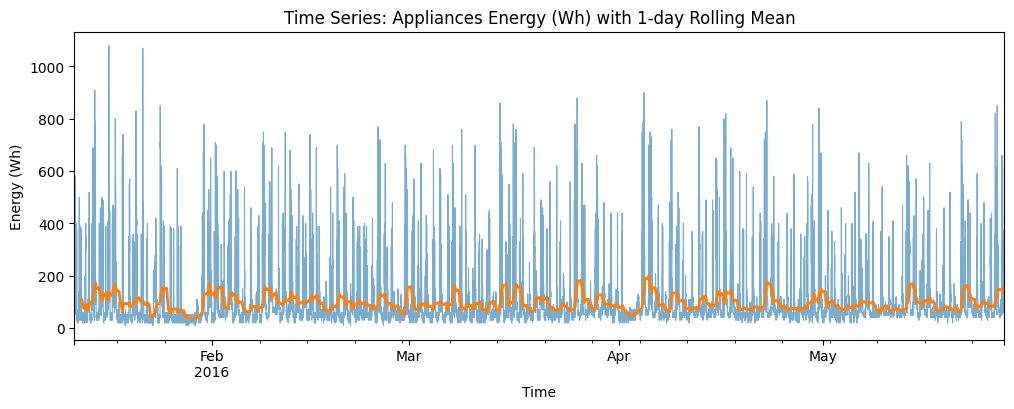

In [41]:
plt.figure(figsize=(12, 4))
df[TARGET_COL].plot(linewidth=0.8, alpha=0.6)
df[TARGET_COL].rolling(ROLLING_WINDOW).mean().plot(linewidth=2)
plt.title("Time Series: Appliances Energy (Wh) with 1-day Rolling Mean")
plt.xlabel("Time")
plt.ylabel("Energy (Wh)")

Below code is for plotting the average energy by hour of day. Average appliance energy consumption by hour of day (0–23). The curve shows a typical daily pattern with low usage overnight, a morning rise, and the strongest peak in the early evening (around 18:00), indicating clear daily seasonality in household energy demand

Text(0, 0.5, 'Average Energy (Wh)')

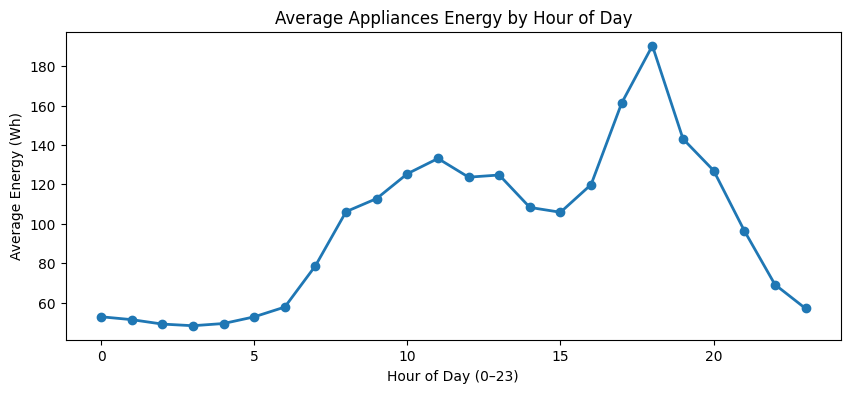

In [ ]:
tmp = df.copy()
tmp["hour"] = tmp.index.hour
hourly_mean = tmp.groupby("hour")[TARGET_COL].mean()

plt.figure(figsize=(10, 4))
hourly_mean.plot(marker="o", linewidth=2)
plt.title("Average Appliances Energy by Hour of Day")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Average Energy (Wh)")

Below code compares the usage between weekdays and weekends

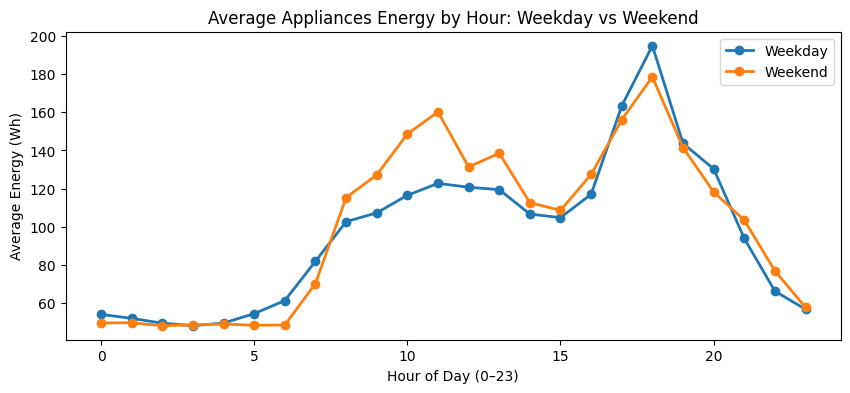

In [43]:
tmp["weekday"] = tmp.index.dayofweek  # Monday=0
tmp["is_weekend"] = tmp["weekday"].isin([5, 6])

weekday_hourly = tmp.loc[~tmp["is_weekend"]].groupby("hour")[TARGET_COL].mean()
weekend_hourly = tmp.loc[tmp["is_weekend"]].groupby("hour")[TARGET_COL].mean()

plt.figure(figsize=(10, 4))
plt.plot(weekday_hourly.index, weekday_hourly.values, marker="o", linewidth=2, label="Weekday")
plt.plot(weekend_hourly.index, weekend_hourly.values, marker="o", linewidth=2, label="Weekend")
plt.title("Average Appliances Energy by Hour: Weekday vs Weekend")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Average Energy (Wh)")
plt.legend()

Below code shows the correlation heatmap between the numerical variables energy, sensor and weather. It uses Pearson correlation between each pair of variables. Yellow correlation close to +1, green will be moderate positive correlation, blue/purple will be negative correation. Temperature variable correlates strongly to each other. Appliance has week to moedrate thus confirming energy peaks not strongly depends on the temperature but also the human behaviour i.e., cooking etc..,  

Text(0.5, 1.0, 'Correlation Heatmap: Appliances vs Top Related Sensor/Weather Features')

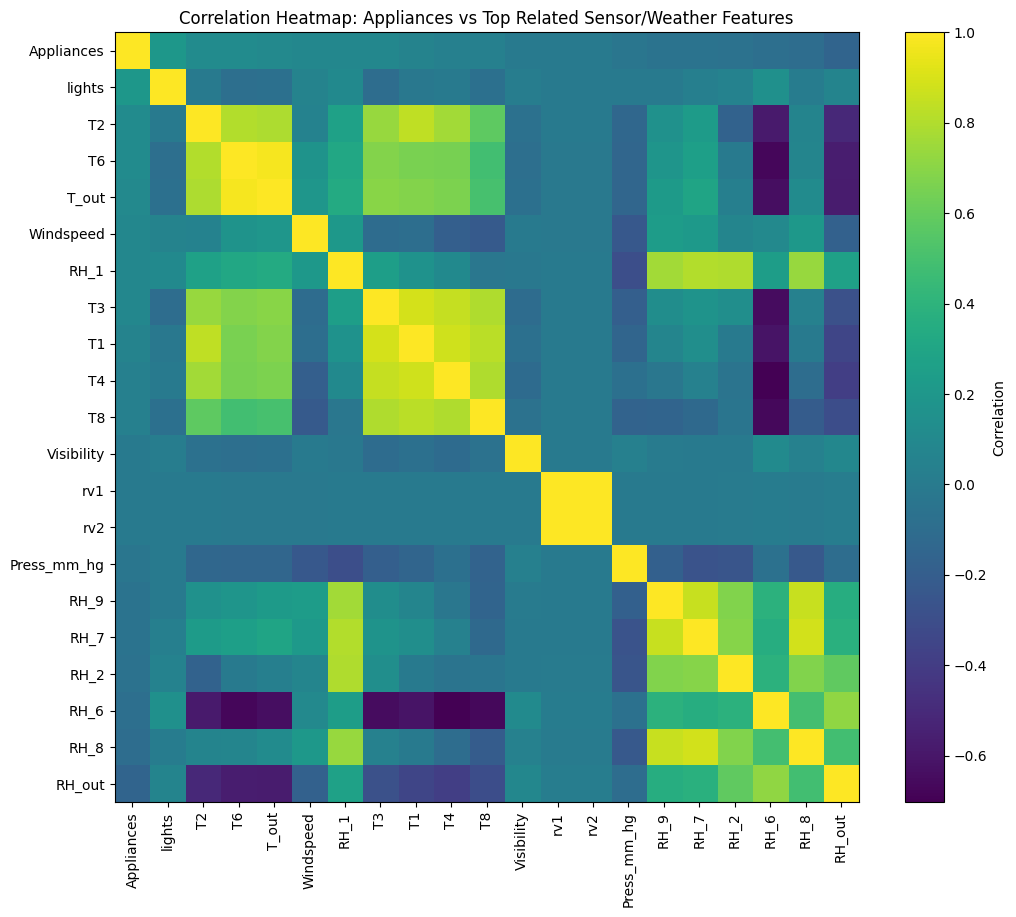

In [44]:
corr = df[num_cols].corr(numeric_only=True)
appl_corr = corr[TARGET_COL].drop(TARGET_COL).sort_values(ascending=False)

top_pos = appl_corr.head(10).index.tolist()
top_neg = appl_corr.tail(10).index.tolist()
heat_cols = [TARGET_COL] + top_pos + top_neg
heat_cols = list(dict.fromkeys(heat_cols))  # remove duplicates

heat = df[heat_cols].corr(numeric_only=True)

plt.figure(figsize=(12, 10))
plt.imshow(heat.values, aspect="auto")
plt.colorbar(label="Correlation")
plt.xticks(range(len(heat_cols)), heat_cols, rotation=90)
plt.yticks(range(len(heat_cols)), heat_cols)
plt.title("Correlation Heatmap: Appliances vs Top Related Sensor/Weather Features")

Below code to show the scatter plot providing the relationship between the appliance energy and sensor data including both indoor and outdoor. 

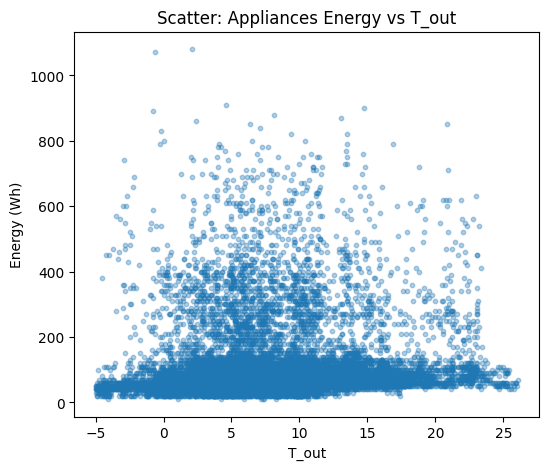

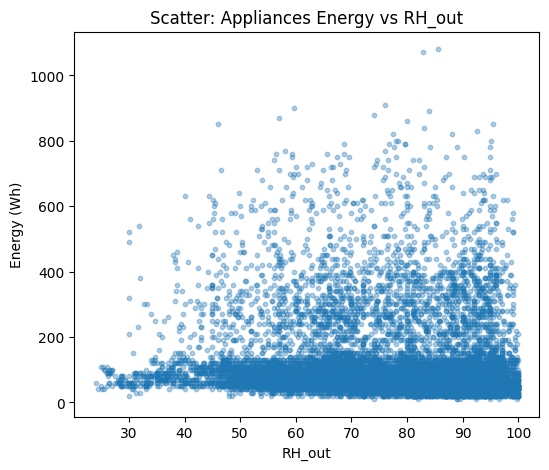

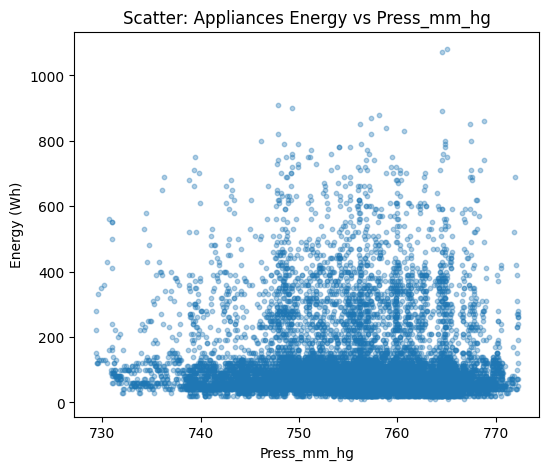

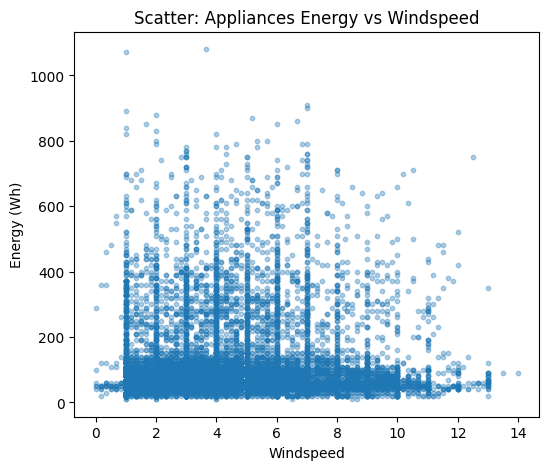

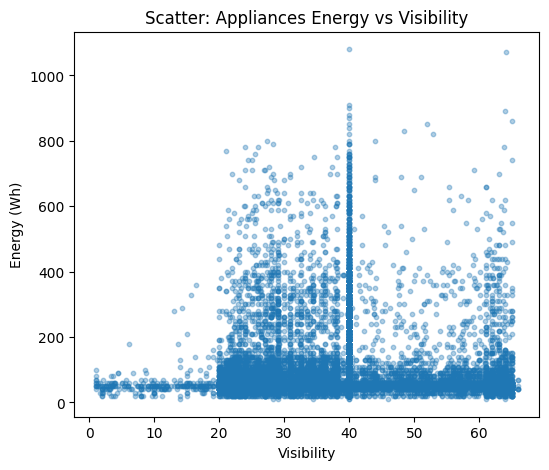

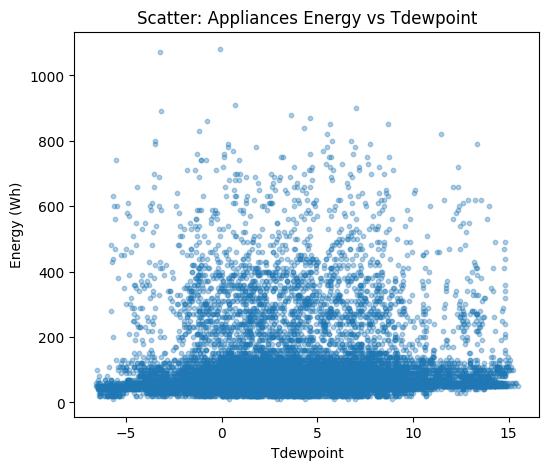

In [45]:
scatter_cols = []

for c in OUTDOOR_CANDIDATES:
    if c in df.columns:
        scatter_cols.append(c)

for c in INDOOR_CANDIDATES:
    if c in df.columns:
        scatter_cols.append(c)

# Limit to a few so it stays report-friendly
scatter_cols = scatter_cols[:6]

for c in scatter_cols:
    plt.figure(figsize=(6, 5))
    plt.scatter(df[c], df[TARGET_COL], s=10, alpha=0.35)
    plt.title(f"Scatter: Appliances Energy vs {c}")
    plt.xlabel(c)
    plt.ylabel("Energy (Wh)")